# Evaluate combinatorial variants

Using the GB1 landscape as a test case. See [here](https://elifesciences.org/articles/16965). Downloaded from [FLIP](https://github.com/J-SNACKKB/FLIP/blob/main/splits/gb1/four_mutations_full_data.csv.zip)

In [1]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
from aide_predict.utils.common import get_supported_tools

In [3]:
get_supported_tools()

/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


ProteinModelWrapper: AVAILABLE
HMMWrapper: AVAILABLE
ESM2LikelihoodWrapper: AVAILABLE
MSATransformerLikelihoodWrapper: AVAILABLE
ESM2Embedding: AVAILABLE
OneHotAlignedEmbedding: AVAILABLE
OneHotProteinEmbedding: AVAILABLE
MSATransformerEmbedding: AVAILABLE



'ProteinModelWrapper: AVAILABLE\nHMMWrapper: AVAILABLE\nESM2LikelihoodWrapper: AVAILABLE\nMSATransformerLikelihoodWrapper: AVAILABLE\nESM2Embedding: AVAILABLE\nOneHotAlignedEmbedding: AVAILABLE\nOneHotProteinEmbedding: AVAILABLE\nMSATransformerEmbedding: AVAILABLE\n'

## Load the dataset

In [4]:
import os
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.utils.validation import check_is_fitted

from aide_predict.bespoke_models import ESM2LikelihoodWrapper
from aide_predict.utils.data_structures import ProteinSequence, ProteinSequences

In [5]:
data = pd.read_csv(os.path.join('data', 'four_mutations_full_data.csv'))[['sequence', 'Fitness', 'three_vs_rest']].dropna()

/var/folders/4b/6yg7r65x0152cnhzpgzdhmvrjcvswz/T/ipykernel_66438/3170391716.py:1: DtypeWarning: Columns (8,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join('data', 'four_mutations_full_data.csv'))[['sequence', 'Fitness', 'three_vs_rest']].dropna()


In [6]:
train_data = data[data['three_vs_rest'] == 'train']
test_data = data[data['three_vs_rest'] == 'test']

In [7]:
train_sequences = ProteinSequences([ProteinSequence(seq) for seq in train_data['sequence']])
test_sequences = ProteinSequences([ProteinSequence(seq) for seq in test_data['sequence']])

In [8]:
train_sequences

ProteinSequences(count=2990, aligned=True, fixed_length=True)

In [9]:
wt = ProteinSequence('MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTELEVLFQGPLDPNSMATYEVLCEVARKLGTDDREVVLFLLNVFIPQPTLAQLIGALRALKEEGRLTFPLLAECLFRAGRRDLLRDLLHLDPRFLERHLAGTMSYFSPYQLTVLHVDGELCARDIRSLIFLSKDTIGSRSTPQTFLHWVYCMENLDLLGPTDVDALMSMLRSLSRVDLQRQVQTLMGLHLSGPSHSQHYRHTPLEHHHHHH', id='wt')

In [10]:
len(wt) == test_sequences.width

True

## Start with zero shot prediction using ESM2

In [13]:
model = ESM2LikelihoodWrapper(
    pool=True, # we want the scores to be averaged over the whole protein
    metadata_folder='tmp', # required for the API, but MSATransformer does not use it
    wt=wt,
    marginal_method='wildtype_marginal',
    device="mps"
)
model.fit([]) #ESM2 requires no fitting sequences

This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.
/Users/ekomp/Documents/repos/lab/aide_predict/aide_predict/bespoke_models/predictors/esm2.py:471: UserWarning: Finetuning ESM models is not yet supported. Using Pretrained model weights.
  warnings.warn("Finetuning ESM models is not yet supported. Using Pretrained model weights.")
/Users/ekomp/miniconda3/envs/aidep/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ESM2LikelihoodWrapper(device='mps', marginal_method='wildtype_marginal',
                      metadata_folder='tmp')

In [14]:
predictions = model.predict(test_sequences)

In [15]:
test_data['esm2 likelihood'] = predictions

/var/folders/4b/6yg7r65x0152cnhzpgzdhmvrjcvswz/T/ipykernel_66438/3187200036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['esm2 likelihood'] = predictions


In [16]:
test_data

,sequence,Fitness,three_vs_rest,esm2 likelihood
28187,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAAEWTYD...,1.611610,test,-3.336921
28200,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAACEWTYD...,3.741833,test,-3.631914
28225,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAEEWTYD...,0.000000,test,-3.808031
28228,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAFEWTYD...,1.081518,test,-3.379137
28231,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAFEWTYD...,2.087250,test,-3.560137
...,...,...,...,...
149271,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYSEWTYD...,0.368577,test,-4.036637
149311,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYVEWTYD...,1.044870,test,-3.757311
149312,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYVEWTYD...,0.002253,test,-3.964759
149352,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGYYYEWTYD...,0.026282,test,-4.279274


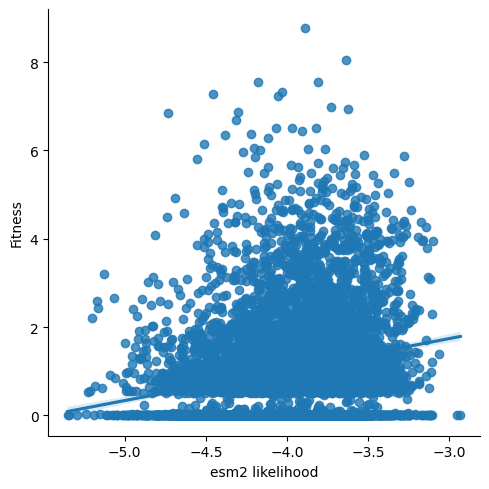

In [17]:
sns.lmplot(x='esm2 likelihood', y='Fitness', data=test_data)

## Instead, train a supervised model on training set

Here we simply OHE the 4 variable positions and use a Random Forest.

In [18]:
variable_positions = train_sequences.mutated_positions
variable_positions

[38, 39, 40, 53]

In [19]:
from aide_predict.bespoke_models import OneHotProteinEmbedding
from sklearn.ensemble import RandomForestRegressor

In [22]:
ohe = OneHotProteinEmbedding(
    positions=variable_positions,
    metadata_folder='tmp')
X_train = ohe.fit_transform(train_sequences)
X_test = ohe.transform(test_sequences)

This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.


In [24]:
model = RandomForestRegressor()
model.fit(X_train, train_data['Fitness'].values)

RandomForestRegressor()

In [25]:
predictions = model.predict(X_test)

In [26]:
test_data['rf_ohe'] = predictions

/var/folders/4b/6yg7r65x0152cnhzpgzdhmvrjcvswz/T/ipykernel_66438/251431820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rf_ohe'] = predictions


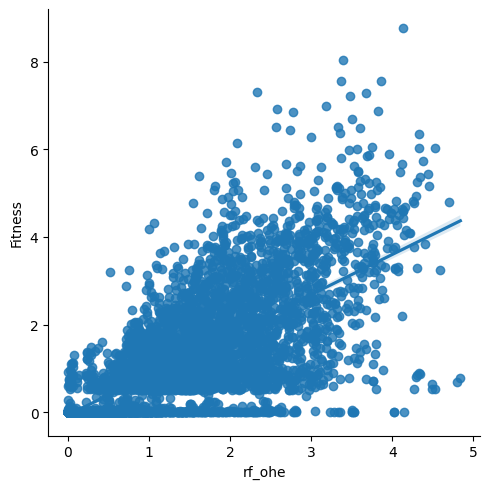

In [27]:
sns.lmplot(x='rf_ohe', y='Fitness', data=test_data)

## Construct a more complicated pipeline

1. Embed sequences with ESM2, only keep positions with mutations from embeddings
2. Add to the embeddings a zero shot score from MSA transformer
3. Standard scale embeddings and run PCA
4. Train a Random Forest on the PCA components

In [28]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from aide_predict.bespoke_models import MSATransformerLikelihoodWrapper, ESM2Embedding

In [29]:
msa = ProteinSequences.from_fasta(os.path.join('data', 'gb1_msa.a2m'))

In [30]:
msalikelihood = MSATransformerLikelihoodWrapper(
    pool=True,
    wt=wt,
    marginal_method='wildtype_marginal',
    device="mps",
    metadata_folder='tmp'
)
msalikelihood.fit(msa)

This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.


MSATransformerLikelihoodWrapper(device='mps',
                                marginal_method='wildtype_marginal',
                                metadata_folder='tmp')

In [37]:
embedder = ESM2Embedding(
    device="mps",
    metadata_folder='tmp',
    positions=variable_positions,
    pool=False,
    flatten=True
)

This model class did not implement check_metadata. If the model requires anything other than raw sequences to be fit, this is unexpected.


In [40]:
scaler = StandardScaler()
pca = PCA(n_components=100)

In [41]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('msa', msalikelihood),
        ('esm2', embedder)
    ])),
    ('scaler', scaler),
    ('pca', pca),
    ('model', RandomForestRegressor())
])

In [43]:
msa.width

448

In [45]:
train_sequences.width * 2

530

In [42]:
pipeline.fit(train_sequences, train_data['Fitness'].values)

Model is already fitted. Skipping


ValueError: Input sequences must have the same length as the original MSA (448).